# Clasificación
**Autor:** José A. Troyano &nbsp;&nbsp;&nbsp; **Revisor:** Beatriz Pontes &nbsp;&nbsp;&nbsp; **Última modificación:** 31/03/2023

---------------------------------------------------------------------
## Contenido

1. <a href="#entrenamiento"> Entrenamiento de un clasificador </a> <br>
    1.1. <a href="#reg_log"> ¿Qué es la regresión logística? ¿Es regresión o clasificación? </a> <br>
    1.2. <a href="#estimador_reg_log"> El estimador _LogisticRegression_ </a>  <br>
2. <a href="#metricas"> Métricas de evaluación </a> <br>
    2.1. <a href="#confusion"> Matriz de confusión: TP, FP, TN, FN </a> <br>
    2.2. <a href="#pcf1"> Precisión, cobertura y f1 </a> <br>
    2.3. <a href="#tpr_fpr"> _True Positive Rate_ y _False Positive Rate_ </a> <br>
    2.4. <a href="#roc_pr"> Curva ROC y curva _Precision-Recall_ </a> <br>
3. <a href="#clasificadores"> Más clasificadores </a> <br>
4. <a href="#fronteras_curvas"> Fronteras de decisión y curvas de aprendizaje </a> <br>
    4.1. <a href="#fronteras"> Fronteras de decisión </a> <br>
    4.2. <a href="#curvas"> Curvas de aprendizaje </a> <br>
------------------------------------------------------

En este notebook veremos cómo entrenar un clasificador de Sklearn y distintas formas de evaluar la calidad del clasificador obtenido. Compararemos varios clasificadores de la oferta disponible en Sklearn y, por último, veremos el aspecto que tienen las fronteras de decisión de cada uno de estos algoritmos de aprendizaje.

Empezaremos por importar todos los elementos que usaremos a lo largo del notebook:

In [2]:
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Numpy, scipy y pandas
import numpy as np
import scipy.stats
import pandas as pd

# Datasets
from sklearn.datasets import load_breast_cancer, make_classification, make_moons, make_circles

# Clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Evaluación
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, learning_curve

# Visualización
import seaborn as sns
from pySankey import sankey     # pip install pySankey
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\valle\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Usaremos el dataset _breast cancer_, disponible en el repositorio UCI y también incluido en el conjunto de datasets de prueba de Sklearn. 

El dataset contiene 569 registros correspondientes a pacientes de cáncer de mama. Los atributos se corresponden con métricas calculadas sobre las células identificadas en imágenes de biopsias. Para cada paciente se realizan 10 métricas sobre varias células, y para cada métrica se registran la media, desviación estándar y peor resultado de todos valores. La clase a predecir es $0$ ó $1$ en función de que el tumor sea maligo o no.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

<Axes: >

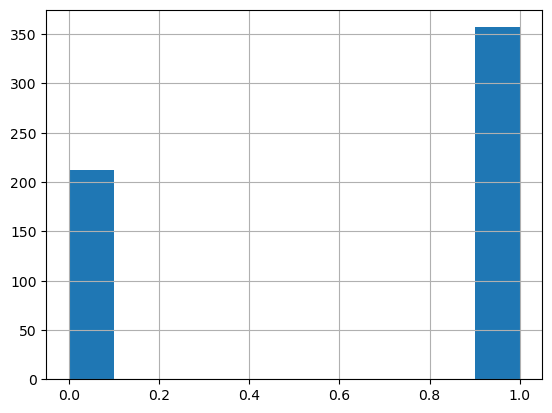

In [3]:
# EJERCICIO: acceder al dataset disponible en sklearn y crear el dataframe 'X' para los atributos, y la serie 'y' para la clase
#    - Mostrar información sobre las columnas
#    - Mostrar con una gráfica la distribución de los valores de la clase

DATOS = load_breast_cancer()

X = pd.DataFrame(DATOS.data, columns=DATOS.feature_names)
y = pd.Series(DATOS.target)

#X = pd.DataFrame(DATOS['data'], columns=DATOS['feature_names'])
#y = pd.Series(DATOS['target'])

# Mostrar información sobre las columnas
X.info()

# Mostrar
y.hist()

In [4]:
# Mostrar la distribución de los valores de la clase con una gráfica - (chaty)
#plt.figure(figsize=(6, 4))

#y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

#plt.title('Distribución de valores de la clase')
#plt.xlabel('Clase')
#plt.ylabel('Frecuencia')
#plt.xticks([0, 1], DATOS.target_names, rotation=0)

#plt.show()

## 1. Entrenamiento de un clasificador <a name="entrenamiento"> </a>

Entrenar un clasificador es muy simple en Sklearn. Basta con crear un objeto del estimador que queramos entrenar y ejecutar el método <code>fit</code>. En este notebook usaremos uno de los clasificadores que mejor resultado suele dar de los disponibles en Sklearn: <code>LogisticRegression</code>. 

### 1.1. ¿Qué es la regresión logística? ¿Es regresión o clasificación? <a name="reg_log"> </a>

Es una técnica que se usa para predecir el resultado de una variable discreta, es por tanto una _técnica de clasificación_. En su formulación más simple (la binaria) se aprende a estimar la probabilidad de que una instancia pertenezca a la clase positiva de la siguiente forma:
- Probabilidades cercanas a $1$ darán lugar a clasificar la instancia como de la clase positiva
- Probabilidades cercanas a $0$ darán lugar a clasificar la instancia como de la clase negativa



El modelo logístico establece la siguiente relación entre la probabilidad de pertenecer a la clase positiva y los valores de los atributos de la instancia $X$:

$$
P(X) = P(y=1\;| \;x_1, x_2, ..., x_n)  = \frac{1}{1+exp(-\alpha-\beta_1x_1-\beta_2x_2...-\beta_nx_n)}
$$

A este tipo de funciones se les denomina _logísticas_ (de ahí el nombre _regresión logística_).

Se puede generalizar a una clasificación no binaria (con $k$ categorías) mediante la construcción de $k-1$ clasificadores binarios.

La función _logit_ nos permite convertir el problema de estimar la probablilidad en un problema de regresión lineal. Esta es la función _logit_:
$$
logit(p) = ln(\frac{p}{1-p})
$$

Y mediante una serie de transformaciones se demuestra que:

$$
logit(P(y=1\;| \;x_1, x_2, ..., x_n)) = \alpha+\beta_1x_1+\beta_2x_2...+\beta_nx_n
$$

Gracias a usar la función _logit_ como función de enlace se consigue una formulación lineal del problema, lo que permite la aplicación de técnicas de regresión lineal (de ahí el nombre _regresión_ logística)  para el aprendizaje de los coeficientes $\alpha$ y $\beta_i$.



### 1.2. El estimador <code>LogisticRegression</code> <a name="estimador_reg_log"> </a>

In [5]:
# EJERCICIO: crear un estimador de la clase LogisticRegression y entrenarlo con el dataset <X,y>

clasificador = LogisticRegression(solver='liblinear'
                                 #max_iter=1000
                                 )

clasificador.fit(X,y)

LogisticRegression(solver='liblinear')

Una vez entrenado un clasificador, podemos usarlo para predecir la clase de un conjunto de instancias con el método <code>predict</code>.

In [6]:
# EJERCICIO: predecir la salida de los primeros 10 valores de X con el clasificador entrenado anteriormente

predicciones = clasificador.predict(X.head(10))
predicciones

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

Podemos aplicar validación cruzada para evaluar. Por defecto la métrica de evaluación es <code>accuracy_score</code> aunque, como veremos en la siguiente sección, hay más métricas implementadas en Sklearn.

In [7]:
# EJERCICIO: predecir la salida de todas las instancias mediante validación cruzada y guardar las prediccciones en y_pred
y_pred = cross_val_predict(clasificador, X, y, cv=10)
y_pred[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [8]:
# EJERCICIO: calcular el score por defecto sobre todas las instancias mediante validación cruzada
scores = cross_val_score(clasificador, X, y, cv=10)
scores.mean()

0.9508145363408522

In [9]:
# EJERCICIO: dividir el dataset <X, y> en dos datasets <X_train, y_train> y <X_test, y_test> con una distribución 80%-20%,
#            entrenar el clasificador con <X_train, y_train> y calcular la métrica accuracy con <X_test, y_test>
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
clasificador.fit(X_train, y_train)
y_test_pred = clasificador.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred)

0.9385964912280702

Una vez entrenado un clasificador, podemos usarlo para predecir la clase de un conjunto de instancias con el método <code>predict</code>. Muchos estimadores nos proporcionan también las probabilidades de cada una de las clases gracias al método <code>predict_proba</code>.

In [10]:
# EJERCICIO: calcular las probabilidades de cada clase para las instancias de X_test y guardarlas en y_test_proba

y_test_proba = clasificador.predict_proba(X_test)
print(y_test_proba[:10])

[[4.05429904e-03 9.95945701e-01]
 [6.85518932e-04 9.99314481e-01]
 [4.29554507e-03 9.95704455e-01]
 [8.46262123e-02 9.15373788e-01]
 [4.77385618e-04 9.99522614e-01]
 [1.00000000e+00 9.13768586e-34]
 [9.99993883e-01 6.11672318e-06]
 [3.48693711e-03 9.96513063e-01]
 [9.99989675e-01 1.03248694e-05]
 [1.62344795e-04 9.99837655e-01]]


Como podemos observar aparecen dos probabilidades para cada fila: la probabilidad de elegir la clase $0$ y la probabilidad de elegir la clase $1$. Un análisis de la distribución de estas probabilidades, nos dará pistas sobre si el conjunto de datos a clasificar está _bien separado_. Si es así, habrá pocos casos dudosos al clasificador le costará menos trabajo decidir.

Text(0.5, 1.0, 'Frecuencia')

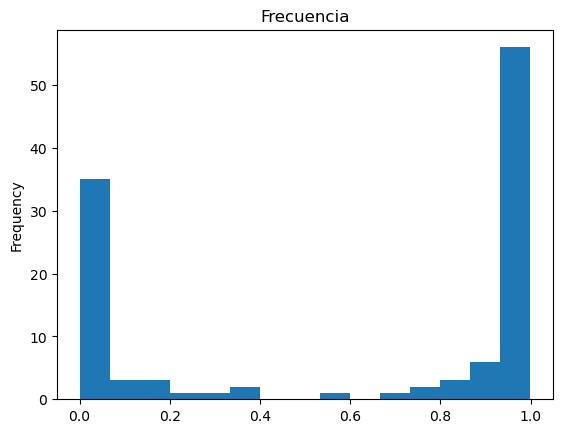

In [11]:
# EJERCICIO: mostrar con un histograma la distribución de la probabilidad de pertenecer a la clase 1

y_test_proba_1 = pd.Series(y_test_proba[:,1])
y_test_proba_1.plot.hist(bins=15)

plt.title('Dsitribución de la probabilidad de predicción')
plt.title('Probabilidad de la clase 1')
plt.title('Frecuencia')

## 2. Métricas de evaluación <a name="metricas"> </a>

A partir de esta sección trabajaremos sobre los resultados de la validación cruzada (mediante las series <code>y</code> e <code>y_pred</code>) aunque el análisis podía haberse hecho perfectamente con una evaluación _train/test_.

### 2.1. Matriz de confusión: TP, FP, TN, FN <a name="confusion"> </a>

La matriz de confusión muestra el número de veces que se han producido los distintos tipos de aciertos y fallos. En una clasificación binaria tiene cuatro celdas que suelen denominarse con los siguientes nombres:
- TP: _true positives_
- TN: _true negatives_
- FP: _false positives_
- FN: _false negatives_

In [12]:
# EJERCICIO: crear la matriz de confusión a partir de 'y' e 'y_pred' en un DataFrame con esta estructura:
#   - Columnas: [0,1]
#   - Índice: [0,1]

from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y, y_pred)

# Crear un DataFrame a partir de la matriz de confusión
conf_matrix_df = pd.DataFrame(conf_matrix,
                              columns=['0', '1'], #predicted
                              index=['0', '1'] #actual
                             )

conf_matrix_df

,0,1
0,194,18
1,10,347


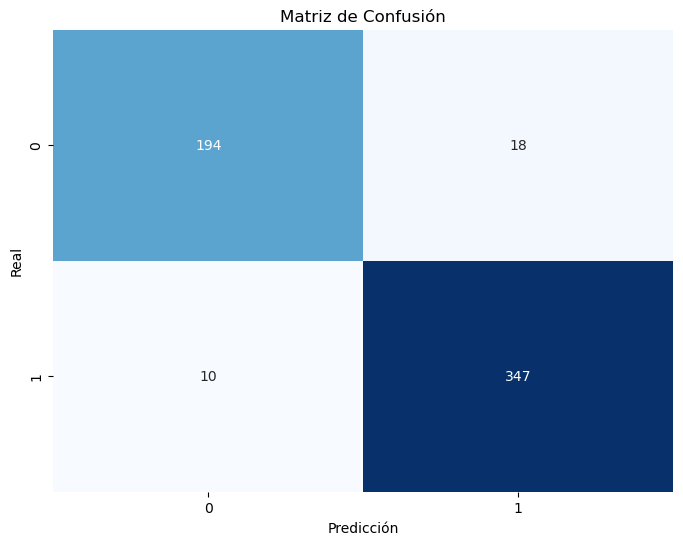

In [13]:
# EJERCICIO: mostrar la matriz de confusión mediante un mapa de calor de Seaborn

# Crear el mapa de calor utilizando Seaborn
plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            #xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1']
           )

plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [14]:
# EJERCICIO: obtener una versión apilada de la matriz de confusión en un DataFrame con las siguientes características:
#   - Tantas filas como valores tenga la matriz de confusión
#   - Cada fila registrará el número de casos de cada situación posible, y estará caracterizada por tres columnas: 
#        * 'Real': etiqueta real en el dataset
#        * 'Prediccion': etiqueta resultado de la predicción 
#        * 'Número casos': número de casos que se han dado para esa situación

# Apilar el DataFrame para obtener una versión apilada de la matriz de confusión
matriz_apilada = conf_matrix_df.stack().reset_index()
matriz_apilada.columns = ['Real', 'Prediccion', 'Número casos']

matriz_apilada

,Real,Prediccion,Número casos
0,0,0,194
1,0,1,18
2,1,0,10
3,1,1,347


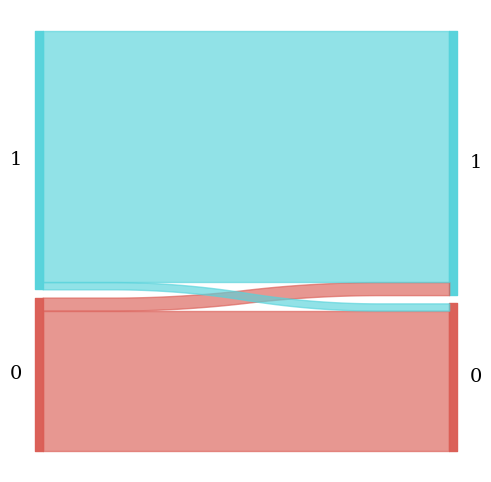

In [15]:
# EJERCICIO: mostrar la matriz de confusión mediante un diagrama de Sankey (usando la matriz apilada)
sankey.sankey(left=matriz_apilada['Real'],
             right=matriz_apilada['Prediccion'],
             leftWeight=matriz_apilada['Número casos'])

In [16]:
# EJERCICIO: calcular TP, FP, TN y FN a partir de la matriz de confusión anterior

TP = conf_matrix[1, 1]  # Verdaderos positivos
FN = conf_matrix[1, 0]  # Falsos negativos

FP = conf_matrix[0, 1]  # Falsos positivos
TN = conf_matrix[0, 0]  # Verdaderos negativos


Una de las métricas más usadas es el _accuracy_ que mide directamente el porcentaje de aciertos. Si el dataset está balanceado es un buen indicador, pero si alguna de las clases es muy mayoritaria (o minoritaria) la información que nos dá la métrica puede ser bastante engañosa. En las siguientes secciones veremos otras métricas que son menos sensibles a datasets mal balanceados.

### 2.2. Precisión, cobertura y f1 <a name="pcf1"> </a>

El siguiente paquete de métricas es el formado por la precisión, cobertura (_recall_) y medida f1. Son métricas que dan diferente importancia al tipo de error (p.e. falsos positivos o falsos negativos en clasificación binaria). Pueden ser de utilidad para sistemas en los que nos preocupan más unos errores que otros: por ejemplo, es menos grave dejar pasar un correo _spam_ que eliminar un correo correcto. El significado intuitivo de las métricas es el siguiente:
- _precision_: grado de acierto en las instancias propuestas como positivas (¿son todos los que están?)
- _recall_: porcentaje de recuperación del total de las instancias positivas (¿están todos los que son?)
- _f1_ : media armónica de precisión y cobertura.

Al combinar dos métricas complementarias, la medida _f1_ es apropiada para datasets que no estén bien balanceados.

In [17]:
# EJERCICIO: calcular la medida 'precisión' a partir de 'y' e 'y_pred'

from sklearn.metrics import accuracy_score
precision = accuracy_score(y, y_pred)

#precision = TP / (TP + FP)

In [18]:
# EJERCICIO: calcular la medida 'cobertura' a partir de 'y' e 'y_pred'

from sklearn.metrics import recall_score
recall = recall_score(y, y_pred)

#recall = TP / (TP + FN)

In [19]:
# EJERCICIO: calcular la medida 'f1' a partir de 'y' e 'y_pred'

from sklearn.metrics import f1_score
f1 = f1_score(y, y_pred)

#f1 = 2 * (precision * recall) / (precision + recall)


### 2.3. _True Positive Rate_ y _False Positive Rate_ <a name="tpr_fpr"> </a>
Las siguientes dos métricas también suelen ir de la mano y, al igual que la precisión y la cobertura, son complementarias. Se trata de TPR (_True Positive Rate_) y FPR (_False Positive Rate_) y se definen de la siguiente forma:

- TPR: positivos correctos (TP) dividido entre todos los positivos (TP+FN). También se denomina a esta métrica _sensibilidad_ y _cobertura_.
- FPR: positivos erróneos (FP) dividido entre todos los negativos (FP+TN). A la métrica $1-FPR$ también se le denomina _especificidad_.

Ambas métricas se suelen combinar en una curva, denominada ROC, que veremos en la siguiente sección.

In [20]:
# EJERCICIO: calcular la medida TPR a partir de los componentes de la matriz de confusión

# Calcular TPR
TPR = TP / (TP + FN)

print("TPR (True Positive Rate):", TPR)

TPR (True Positive Rate): 0.9719887955182073


In [21]:
# EJERCICIO: calcular la medida FPR a partir de los componentes de la matriz de confusión

# Calcular FPR
FPR = FP / (FP + TN)

print("FPR (False Positive Rate):", FPR)

FPR (False Positive Rate): 0.08490566037735849


### 2.4. Curva ROC y curva _Precision-Recall_ <a name="roc_pr"> </a>

Ambas curvas (y sus correspondientes métricas de agregación) se benefician de la complementariedad de las métricas en las que se apoyan para definir unas métricas que tengan en cuenta los distintos tipos de errores que se pueden cometer.

La principal contribución de estas curvas con respecto a otras métricas es que muestran la calidad del clasificador en distintos escenarios de decisión, diferenciados por el umbral de probabilidad usado para determinar la clase. Esto se puede hacer siempre que dispongamos las probabilidades generadas por <code>predict_proba</code>.

Probando distintos umbrales de decisión, obtendremos métricas distintas. Y es, precisamente, con esos puntos con los que se trazan ambas curvas. La definición intuitiva de cada una de ellas es la siguente:
- Curva ROC: unión de puntos (FPR, TPR) con distintos umbrales de decisión. La métrica ROC-AUC resume la curva en un único valor numérico mediante el área que queda bajo ella.
- Curva _Precision-Recall_: unión de puntos (_recall_, _precision_) con distintos umbrales de decisión. La métrica _average precision score_ resume la curva en un único valor numérico mediante el área que queda bajo ella.

El hecho de que ambas curvas integren métricas complementarias y que se apoyen en distintos umbrales de decisión, las hacen muy apropiadas para situaciones en las que el dataset no está balanceado.

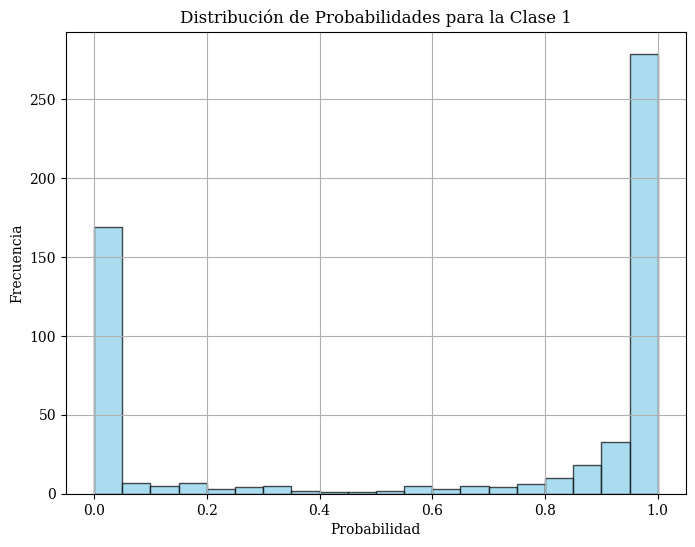

In [22]:
# EJERCICIO: calcular mediante validación cruzada y_proba e y_proba_clase1, mostrar esta última distribución con un histograma


# Calcular las probabilidades de cada clase para todas las instancias mediante validación cruzada
y_proba = cross_val_predict(clasificador, X, y, cv=10, method='predict_proba')

# Seleccionar las probabilidades de la clase 1
y_proba_clase1 = y_proba[:, 1]

# Mostrar la distribución de y_proba_clase1 con un histograma
plt.figure(figsize=(8, 6))
plt.hist(y_proba_clase1, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribución de Probabilidades para la Clase 1')
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [23]:
# EJERCICIO: calcular los puntos de la curva ROC

#from sklearn.metrics import roc_curve

# Calcular los puntos de la curva ROC
fpr, tpr, thresholds = metrics.roc_curve(y, y_proba_clase1)

print('FPR: ', fpr[:5])
print('TPR: ', tpr[:5])


FPR:  [0.         0.         0.         0.00471698 0.00471698]
TPR:  [0.         0.00280112 0.67226891 0.67226891 0.83473389]


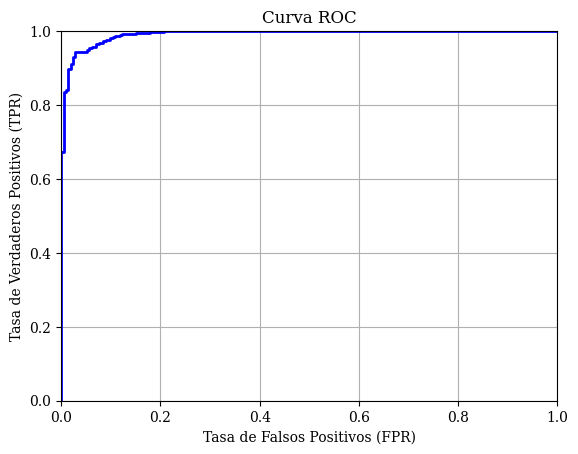

In [24]:
# EJERCICIO: mostrar gráficamente la curva ROC

# Graficar la curva ROC
#plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color='blue', lw=2)

#plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1) ----Dibuja una línea diagonal gris que encuadra el grafico

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title('Curva ROC')

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')

#plt.legend(loc='lower right')

plt.grid(True)
plt.show()


In [25]:
# EJERCICIO: calcular la métrica ROC-AUC

from sklearn.metrics import roc_auc_score

# Calcular la métrica ROC-AUC
roc_auc = roc_auc_score(y, y_proba_clase1)

print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.9918608953015169


In [26]:
# EJERCICIO: calcular los puntos de la curva Precision-Recall

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y, y_proba_clase1)


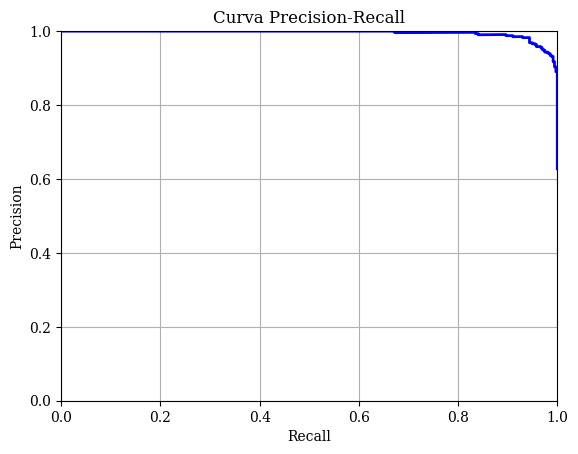

In [27]:
# EJERCICIO: mostrar gráficamente la curva Precision-Recall

#plt.figure(figsize=(8, 6))

plt.plot(recall, precision, color='blue', lw=2)

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Curva Precision-Recall')

#plt.legend(loc='lower left')

plt.grid(True)
plt.show()


In [28]:
# EJERCICIO: calcular la métrica average_precision_score

average_precision = metrics.average_precision_score(y, y_proba_clase1)

## 3. Más clasificadores <a name="clasificadores"> </a>

En esta sección veremos algunas técnicas más de clasificación de la oferta de sklearn. Para comparar los distintos métodos, almacenaremos los resultados en el siguiente dataframe con cuatro columnas, tres de ellas serán métricas (_accuracy_, _f1_ y _roc-auc_) y la última el tiempo de ejecución:

In [29]:
# DataFrame donde iremos guardando los resultados de los experimentos
RESULTADOS = pd.DataFrame(columns=['ACCURACY', 'F1', 'ROC-AUC', 'TIEMPO'])

In [30]:
# EJERCICIO: implementar la función 'experimento' que encapsule todos los pasos de un experimento de clasificación
#    PARÁMETROS DE ENTRADA:
#       - clasificador: estimador usado en el experimento
#       - X: matriz de atributos
#       - y: vector de salida
#    SALIDAS:
#       - Tupla (accuracy, f1, roc-auc, tiempo) con las métricas del experimento y el tiempo invertido en segundos

def experimento(clasificador, X, y):
    inicio = time.time()

    y_pred = cross_val_predict(clasificador, X, y)
    y_proba = cross_val_predict(clasificador, X, y, method='predict_proba')
    y_proba_clase1 =  pd.Series(y_proba[:,1])
    
    accuracy = metrics.accuracy_score(y, y_pred)
    f1 = metrics.f1_score(y, y_pred)
    roc_auc = metrics.roc_auc_score(y, y_proba_clase1)
    
    fin = time.time()
    
    return accuracy, f1, roc_auc, fin-inicio

In [31]:
# EJERCICIO: usar la función experimento para completar la tabla RESULTADOS. Usar los siguientes clasificadores:
#    - Clasificador lienal con SGDClassifier
#    - Clasificación cuadrático basado en SGDClassifier (hay que usar Pipeline y PolynomialFeatures)
#    - Vecinos más cercanos, con valores para k en [1, 3, 5, 7]
#    - Naive Bayes
#    - Regresión Logística (para ested ataset igual hay que ampliar el número másximo de iteraciones)
#    - Support Vector Classifier, con valores para kernel en ['linear', ‘poly’, ‘rbf’, ‘sigmoid’]
#    - Árbol de decisión
#    - Random Forests, con valores para n_estimators en [10, 100, 1000]
#    - Extra trees, con valores para n_estimators en [10, 100, 1000]
#    - Gradient Boosting Classifier
#    - Votación con Naive Bayes, Random Forests(100), Extra Trees(100) 

import time
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import pandas as pd

# Inicializar el DataFrame RESULTADOS
RESULTADOS = pd.DataFrame(columns=['Accuracy', 'F1', 'ROC-AUC', 'Tiempo'])

# Definir los clasificadores
clasificadores = {
    'SGDClassifier': SGDClassifier(),
    'Polynomial SGDClassifier': Pipeline([('poly', PolynomialFeatures()), ('sgd', SGDClassifier())]),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC_linear': SVC(kernel='linear'),
    'SVC_poly': SVC(kernel='poly'),
    'SVC_rbf': SVC(kernel='rbf'),
    'SVC_sigmoid': SVC(kernel='sigmoid'),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier_10': RandomForestClassifier(n_estimators=10),
    'RandomForestClassifier_100': RandomForestClassifier(n_estimators=100),
    'RandomForestClassifier_1000': RandomForestClassifier(n_estimators=1000),
    'ExtraTreesClassifier_10': ExtraTreesClassifier(n_estimators=10),
    'ExtraTreesClassifier_100': ExtraTreesClassifier(n_estimators=100),
    'ExtraTreesClassifier_1000': ExtraTreesClassifier(n_estimators=1000),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'VotingClassifier': VotingClassifier(estimators=[
        ('nb', GaussianNB()),
        ('rf', RandomForestClassifier(n_estimators=100)),
        ('et', ExtraTreesClassifier(n_estimators=100))
    ])
}

# Realizar experimentos para cada clasificador y completar la tabla RESULTADOS
for nombre, metodo in clasificadores.items():
    accuracy, f1, roc_auc, tiempo = experimento(metodo, X, y)
    RESULTADOS.loc[nombre] = [accuracy, f1, roc_auc, tiempo]

print(RESULTADOS)


AttributeError: probability estimates are not available for loss='hinge'

## 4. Fronteras de decisión y curvas de aprendizaje <a name="fronteras_curvas"> </a>

La siguiente figura muestra gráficamente las situaciones de _underfitting_, _good fitting_, _overfitting_ en una tarea de clasificación:

<img src="./img/under-good-over.jpg" alt="Drawing" style="width:10cm;"/>

En esta sección veremos cómo las curvas de aprendizaje nos ayudan a detectar situaciones de un mal ajuste. Y en el caso de datasets de dos atributos podremos, además, visualizar esas situaciones de forma intuitiva gracias a las fronteras de decisión.

### 4.1. Fronteras de decisión <a name="fronteras"> </a>

In [33]:
# Creación de los datasets sintéticos MANCHAS, LUNAS y CIRCULOS

# MANCHAS
X_MANCHAS, y_MANCHAS = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2)
X_MANCHAS = pd.DataFrame(X_MANCHAS, columns=['x', 'y'])

# LUNAS
X_LUNAS, y_LUNAS = make_moons(n_samples=500, noise=0.2, random_state=1)
X_LUNAS = pd.DataFrame(X_LUNAS, columns=['x', 'y'])

# CIRCULOS
X_CIRCULOS, y_CIRCULOS = make_circles(n_samples=500, noise=0.1, random_state=1, factor=0.5)
X_CIRCULOS = pd.DataFrame(X_CIRCULOS, columns=['x', 'y'])


In [71]:
# EJERCICIO: definir la función muestra_puntos que muestre los puntos de un dataset de dos atributos y dos clases
#   ENTRADA:
#    - X: dataframe de de atributos (de dos columnas)
#    - y: vector de la clase (con dos valores posibles)
#   SALIDA:
#   - Diagrama de puntos en rojo para una clase y en azul para otra

'''

def muestra_puntos(X, y):
    
    # Separar los puntos por clase
    X_class_0 = X[y == 0]
    X_class_1 = X[y == 1]
    
    # Graficar los puntos
    plt.figure(figsize=(8, 6))
    plt.scatter(X_class_0['x'], X_class_0['y'], color='blue', label='Clase 0')
    plt.scatter(X_class_1['x'], X_class_1['y'], color='red', label='Clase 1')
    plt.xlabel('Atributo 1')
    plt.ylabel('Atributo 2')
    plt.title('Diagrama de Puntos')
    plt.legend()
    plt.show()

# Usar la función para mostrar los puntos del conjunto de datos MANCHAS
muestra_puntos(X_MANCHAS, y_MANCHAS)
'''

"\n\ndef muestra_puntos(X, y):\n    \n    # Separar los puntos por clase\n    X_class_0 = X[y == 0]\n    X_class_1 = X[y == 1]\n    \n    # Graficar los puntos\n    plt.figure(figsize=(8, 6))\n    plt.scatter(X_class_0['x'], X_class_0['y'], color='blue', label='Clase 0')\n    plt.scatter(X_class_1['x'], X_class_1['y'], color='red', label='Clase 1')\n    plt.xlabel('Atributo 1')\n    plt.ylabel('Atributo 2')\n    plt.title('Diagrama de Puntos')\n    plt.legend()\n    plt.show()\n\n# Usar la función para mostrar los puntos del conjunto de datos MANCHAS\nmuestra_puntos(X_MANCHAS, y_MANCHAS)\n"

In [72]:
def muestra_puntos(X, y):
    datos = pd.DataFrame(X.values, columns=['x_1', 'x_2'])
    datos['y'] = y
    plt.figure(figsize=(6,6))
    sns.scatterplot(x='x_1', y='x_2', hue='y', data=datos, palette=['red', 'blue'], legend=False)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

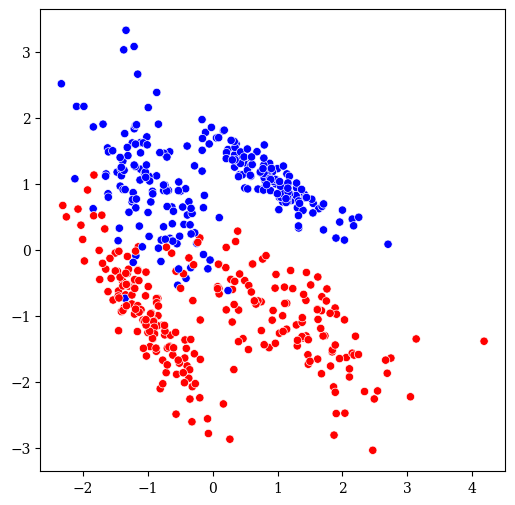

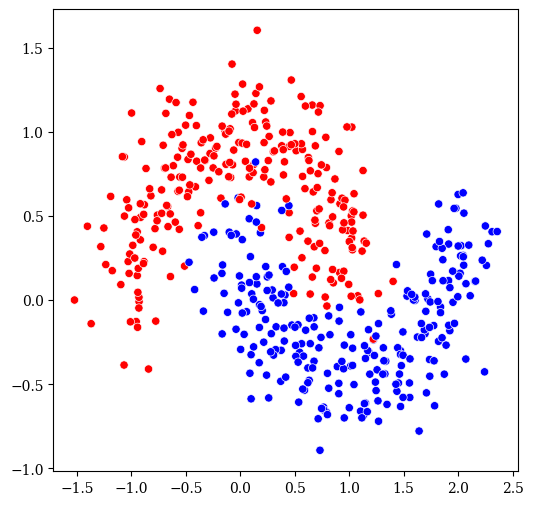

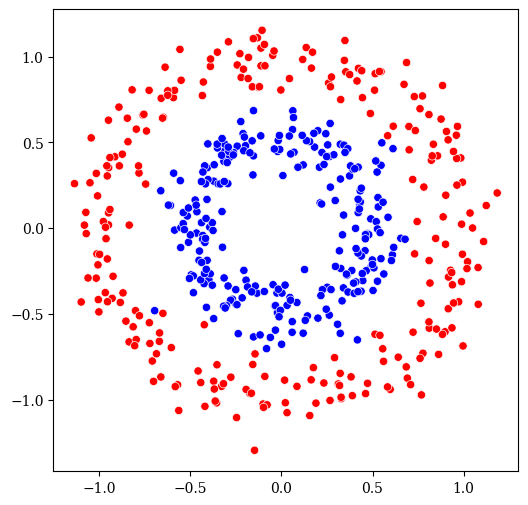

In [73]:
# EJERCICIO: mostrar los puntos de los datasets MANCHAS, LUNAS y CIRCULOS
muestra_puntos(X_MANCHAS, y_MANCHAS)
muestra_puntos(X_LUNAS, y_LUNAS)
muestra_puntos(X_CIRCULOS, y_CIRCULOS)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


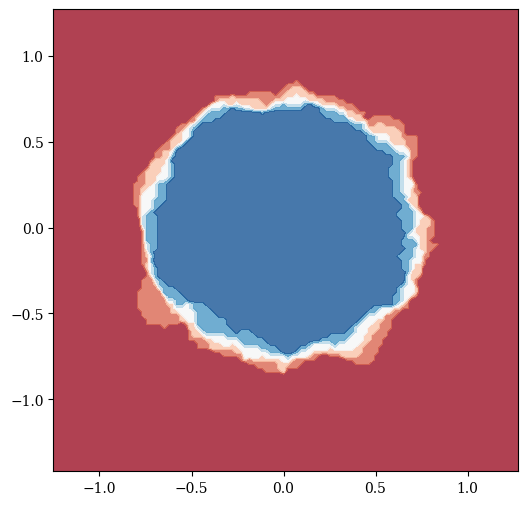

In [74]:
# El siguiente fragmento de código permite mostrar la frontera de decisión de un clasificador
#   - Está inspirado en https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
#   - Lo probaremos con el dataset CIRCULOS con el clasificador KNeighborsClassifier

# -----------------------------------
# Ejemplo de configuración
# -----------------------------------
from sklearn.neighbors import KNeighborsClassifier
X = X_CIRCULOS
y = y_CIRCULOS
clasificador = KNeighborsClassifier()

# -----------------------------------
# Código para la visualización
# -----------------------------------
plt.figure(figsize=(6,6))
datos = pd.DataFrame(X.values, columns=['x', 'y'])
datos['clase'] = y
x_min, x_max = datos['x'].min(), datos['x'].max()
y_min, y_max = datos['y'].min(), datos['y'].max()
rango_x = x_max - x_min
rango_y = y_max - y_min
margen = 0.05
x_min, x_max = x_min-margen*rango_x, x_max+margen*rango_x
y_min, y_max = y_min-margen*rango_y, y_max+margen*rango_y
paso_grid = min(rango_x/100, rango_y/100)
xx, yy = np.meshgrid(np.arange(x_min, x_max, paso_grid),
                     np.arange(y_min, y_max, paso_grid))
score = cross_val_score(clasificador, X,y).mean()
clasificador.fit(X,y)
cm = plt.cm.RdBu
if hasattr(clasificador, "decision_function"):
    Z = clasificador.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clasificador.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

In [90]:
# EJERCICIO: definir la función 'muestra_puntos_y_frontera' que muestre los puntos de
#            un dataset y la frontera de decisión de un clasificador. Usar los siguientes
#            elementos:
#                 - Código de la función muestra_puntos
#                 - Código para visualizar la frontera de decisión
#   ENTRADA:
#    - clasificador: usado para entrenar el modelo
#    - X: dataframe de de atributos (de dos columnas)
#    - y: vector de la clase (con dos valores posibles)
#    - titulo: el título de la gráfica, se mostrará también el accuracy calculado mediante CV
#    - subplot: 3-tupla con el subplot donde colocar la gráfica (por defecto None)
#               INCLUIR AL PRINCIPIO:
#                       if subplot!=None:
#                           plt.subplot(subplot[0], subplot[1], subplot[2])
#               INCLUIR AL FINAL:
#                       if subplot==None:
#                           plt.show()
#    - rango_y: valores mínimo y máximo del eje y (por defecto None)
#                 
#   SALIDA:
#   - Diagrama de puntos sobre la frontera de decisión frontera de decisión 


def muestra_puntos_y_frontera(clasificador, X, y, titulo, subplot=None, rango_y=None):
    
    # Visualizar la frontera de decisión
    datos = pd.DataFrame(X.values, columns=['x', 'y'])
    datos['clase'] = y
    
    x_min, x_max = datos['x'].min(), datos['x'].max()
    y_min, y_max = datos['y'].min(), datos['y'].max()
    
    rango_x = x_max - x_min
    rango_y = y_max - y_min 
    
    margen = 0.05
    
    x_min, x_max = x_min - margen * rango_x, x_max + margen * rango_x
    y_min, y_max = y_min - margen * rango_y, y_max + margen * rango_y
    paso_grid = min(rango_x / 100, rango_y / 100)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, paso_grid),
                         np.arange(y_min, y_max, paso_grid))
    
    #score = cross_val_score(clasificador, X, y).mean()
    clasificador.fit(X, y)
    cm = plt.cm.RdBu
    if hasattr(clasificador, "decision_function"):
        Z = clasificador.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clasificador.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    
    sns.scatterplot(x='x', y='y', hue='clase', data=datos, palette=['red', 'blue'], legend=False)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


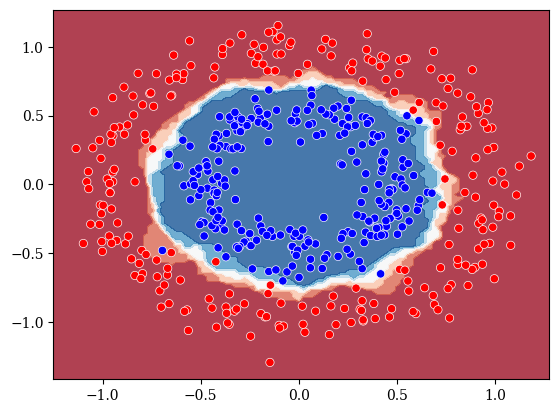

In [91]:
from sklearn.neighbors import KNeighborsClassifier

clasificador = KNeighborsClassifier()
X = X_CIRCULOS
y = y_CIRCULOS
titulo = 'Frontera de Decisión con KNeighborsClassifier'

muestra_puntos_y_frontera(clasificador, X, y, titulo)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


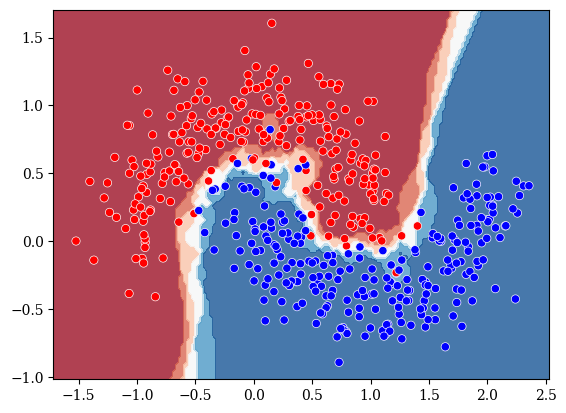

In [92]:
muestra_puntos_y_frontera(clasificador, X_LUNAS, y_LUNAS, titulo)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


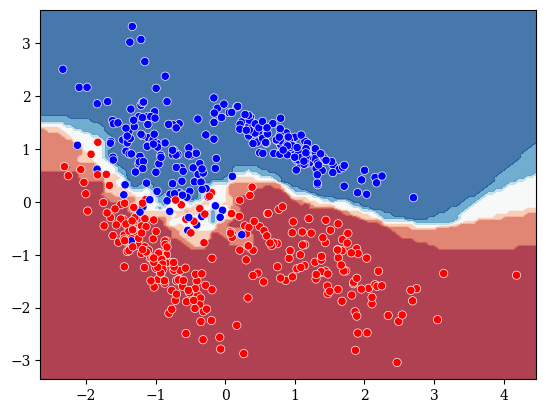

In [93]:
muestra_puntos_y_frontera(clasificador, X_MANCHAS, y_MANCHAS, titulo)

### 4.2. Curvas de aprendizaje <a name="curvas"> </a>

In [96]:
# EJERCICIO: adaptar la función 'muestra_curva_aprendizaje_tamaño' del notebook de regresión para clasificación
#   ENTRADA:
#    - estimador: sobre el que se realiza el experimento
#    - porcentaje_train: porcentaje dedicado a entrenamiento
#    - tamaño_inicial: del primer subconjunto de entrenamiento
#    - numero_subconjuntos: se calcularña un punto de la curva por cada subconjunto
#    - scoring: método de scoring (por defecto 'accuracy')
#    - cv: número de carpetas de la validación cruzada (por defecto 5)
#    - subplot: 3-tupla con el subplot donde colocar la gráfica (por defecto None)
#               INCLUIR AL PRINCIPIO:
#                       if subplot!=None:
#                           plt.subplot(subplot[0], subplot[1], subplot[2])
#               INCLUIR AL FINAL:
#                       if subplot==None:
#                           plt.show()   
#      
#   SALIDA:
#   - Curva de aprendizaje con trazo discontinuo rojo para entrenamiento, y continuo azul para validación


def muestra_curva_aprendizaje_tamaño(estimador, X, y, porcentaje_train=0.8, tamaño_inicial=0.1, numero_subconjuntos=5, scoring='accuracy', cv=5, subplot=None):
    if subplot != None:
        plt.subplot(subplot[0], subplot[1], subplot[2])

    tamaños, train_scores, test_scores = learning_curve(estimador, X, y, train_sizes=np.linspace(tamaño_inicial, porcentaje_train, numero_subconjuntos), cv=cv, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(tamaños, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(tamaños, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(tamaños, train_scores_mean, 'o-', color="r", label="Entrenamiento")
    plt.plot(tamaños, test_scores_mean, 'o-', color="b", label="Validación")

    plt.xlabel("Tamaño del conjunto de entrenamiento")
    plt.ylabel("Puntuación " + scoring)
    plt.legend(loc="best")

    if subplot == None:
        plt.show()


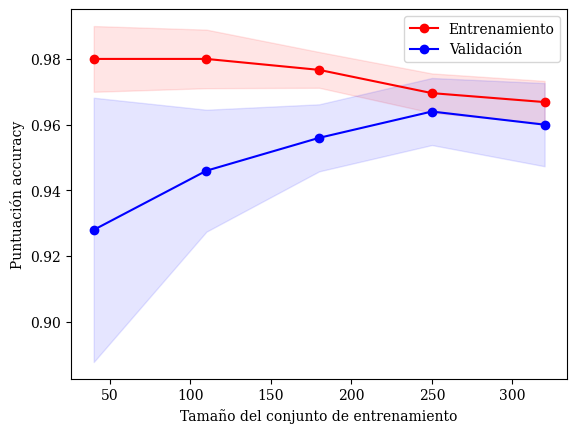

In [79]:
muestra_curva_aprendizaje_tamaño(clasificador, X, y)

In [99]:
# EJERCICIO: mostrar las siguientes curvas para el dataset MANCHAS:
#    - frontera de decisón en subplot (1,2,1)
#    - curva de aprendizaje según tamaño en subplot (1,2,2)        
# Usar los siguientes parámetros para la curva de aprendizaje:
#    - porcentaje de train: 80
#    - tamaño de conjunto inicial: 20
#    - número de conjuntos: 20
# Probar los siguientes clasificadores:
#    - Clasificador lienal con SGDClassifier
#    - Clasificación cuadrático basado en SGDClassifier (hay que usar Pipeline y PolynomialFeatures)
#    - Vecinos más cercanos, con valores para k en [1, 3, 5, 7]
#    - Naive Bayes
#    - Support Vector Classifier, con valores para kernel en ['linear', ‘poly’, ‘rbf’, ‘sigmoid’]
#    - Support Vector Classifier, con kernel 'rbf' y valores para 'gamma' en [0.1, 1, 10, 100]
#    - Stochastic Gradient Descent
#    - Árbol de decisión
#    - Random Forests, con valores para n_estimators en [10, 100, 1000]
#    - Extra trees, con valores para n_estimators en [10, 100, 1000]
#    - Gradient Boosting Classifier
#    - Votación con Naive Bayes, Random Forests(100), Extra Trees(100) 

# EJERCICIO: mostrar las siguientes curvas para el dataset MANCHAS:
#    - frontera de decisón en subplot (1,2,1)
#    - curva de aprendizaje según tamaño en subplot (1,2,2)        
# Usar los siguientes parámetros para la curva de aprendizaje:
#    - porcentaje de train: 80
#    - tamaño de conjunto inicial: 20
#    - número de conjuntos: 20
# Probar los siguientes clasificadores:
#    - Clasificador lienal con SGDClassifier
#    - Clasificación cuadrático basado en SGDClassifier (hay que usar Pipeline y PolynomialFeatures)
#    - Vecinos más cercanos, con valores para k en [1, 3, 5, 7]
#    - Naive Bayes
#    - Support Vector Classifier, con valores para kernel en ['linear', ‘poly’, ‘rbf’, ‘sigmoid’]
#    - Support Vector Classifier, con kernel 'rbf' y valores para 'gamma' en [0.1, 1, 10, 100]
#    - Stochastic Gradient Descent
#    - Árbol de decisión
#    - Random Forests, con valores para n_estimators en [10, 100, 1000]
#    - Extra trees, con valores para n_estimators en [10, 100, 1000]
#    - Gradient Boosting Classifier
#    - Votación con Naive Bayes, Random Forests(100), Extra Trees(100) 


from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

X, y = X_MANCHAS, y_MANCHAS

clasificadores = [
    (SGDClassifier(loss='log'),'SGD'),
    (Pipeline([('cuadratic', PolynomialFeatures(degree=2)), ('SGD', SGDClassifier(loss='log'))]),'Clasificación cuadrática'),
    (KNeighborsClassifier(1), 'Vecinos más cercanos - 1'),
    (KNeighborsClassifier(3), 'Vecinos más cercanos - 3'),
    (KNeighborsClassifier(5), 'Vecinos más cercanos - 5'),
    (KNeighborsClassifier(7), 'Vecinos más cercanos - 7'),
    (GaussianNB(), 'Naive Bayes'),
    (LogisticRegression(), 'Regresión logística'),
    (SVC(kernel='linear'), 'SVC - linear'),
    (SVC(kernel='poly'), 'SVC - poly'),
    (SVC(kernel='sigmoid'), 'SVC - sigmoid'),    
    (SVC(kernel='rbf'), 'SVC - rbf'),
    (SVC(kernel='rbf', gamma=0.1), 'SVC - rbf - gamma:0.1'),
    (SVC(kernel='rbf', gamma=1), 'SVC - rbf - gamma:1'),
    (SVC(kernel='rbf', gamma=10), 'SVC - rbf - gamma:10'),
    (SVC(kernel='rbf', gamma=100), 'SVC - rbf - gamma:100'),
    (DecisionTreeClassifier(), 'Árbol de decisión'),
    (RandomForestClassifier(), 'RFC'),
    (RandomForestClassifier(n_estimators=500, max_depth=3), 'RFC - 500 - 3'),
    (SGDClassifier(), 'SGD'),
    (ExtraTreesClassifier(10), 'ExtraTrees - 10'),
    (ExtraTreesClassifier(100), 'ExtraTrees - 100'),
    (ExtraTreesClassifier(1000), 'ExtraTrees - 1000'),
    (GradientBoostingClassifier(), 'GBC'),
    (VotingClassifier(estimators=[
         ('et', ExtraTreesClassifier(n_estimators=100)), 
         ('rf', RandomForestClassifier(n_estimators=100)), 
         ('nb', GaussianNB())],
         voting='soft'), 'Voting')
]

for clf, titulo in clasificadores:
    #plt.figure(figsize=(10, 5))
    muestra_puntos_y_frontera(clf, X, y, titulo, 
                              #subplot=(1,2,1)
                             )
    muestra_curva_aprendizaje_tamaño(clf, X, y, 80, 20, 20, 
                                     #subplot=(1,2,2), rango_y=(0.5,1)
                                    )
    plt.show()

InvalidParameterError: The 'loss' parameter of SGDClassifier must be a str among {'squared_error', 'log_loss', 'perceptron', 'huber', 'squared_hinge', 'squared_epsilon_insensitive', 'hinge', 'modified_huber', 'epsilon_insensitive'}. Got 'log' instead.

In [ ]:
# EJERCICIO: repetir el ejercicio anterior para el dataset LUNAS


In [ ]:
# EJERCICIO: repetir el ejercicio anterior para el dataset CIRCULOS
